In [8]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [9]:
dir_github = '/media/rich/Home_Linux_partition/github_repos/'
import sys
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%load_ext autoreload
%autoreload 2
from NBAP import import_data, align_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import time
import copy

import pywavesurfer.ws
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [12]:
from pathlib import Path

dir_s2p              = Path(r'/media/rich/bigSSD/analysis_data/face_rhythm_paper/fig_4/2pRAM_motor_mapping/AEG21/2022_05_16/suite2p_output/suite2p/plane0')

path_ws              = Path(r'/media/rich/bigSSD/analysis_data/face_rhythm_paper/fig_4/2pRAM_motor_mapping/AEG21/2022_05_16/AEG21_2022-05-16_0001.h5')

path_cameraCSV       = Path(r'/media/rich/bigSSD/analysis_data/face_rhythm_paper/fig_4/2pRAM_motor_mapping/AEG21/2022_05_16/20220516AEG21_csv32022-05-16T14_27_31.csv')

path_faceRhythmNWB   = Path(r'/media/rich/bigSSD/analysis_data/face_rhythm_paper/fig_4/2pRAM_motor_mapping/AEG21/2022_05_16/faceRhythm/jobNum_0/batchRun/data/session_batch.nwb')

In [13]:
F , Fneu , iscell , ops , spks , stat , num_frames_S2p = import_data.import_S2p(dir_s2p)

ws_dict = pywavesurfer.ws.loadDataFile(filename=path_ws, format_string='double' )

cameraCSV , signal_GPIO = import_data.import_cameraCSV(path_cameraCSV)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/pywavesurfer/ws.py:46: RuntimeWarning: You are reading a WaveSurfer file version this module was not tested with: file version 1.0.5, latest version tested: 0.97
  warnings.warn('You are reading a WaveSurfer file version this module was not tested with: '


In [14]:
h5_handling.dump_nwb(path_faceRhythmNWB)

CQT
     Sxx_allPixels:    (841, 26, 49269, 2)   ,  float32   ,   8.618528 GB
     Sxx_allPixels_norm:    (841, 26, 49269, 2)   ,  float32   ,   8.618528 GB
     Sxx_allPixels_normFactor:    (49269, 2)   ,  float32   ,   0.000394 GB
     Sxx_xAxis:    (985372,)   ,  float64   ,   0.007883 GB
     freq_idx_toUse:    (30,)   ,  bool   ,   0.0 GB
     freqs_Sxx_all:    (30,)   ,  float64   ,   0.0 GB
     freqs_Sxx_toUse:    (26,)   ,  float64   ,   0.0 GB
Optic Flow
     color_tuples:    (216166, 3)   ,  float64   ,   0.005188 GB
     displacements:    (2665, 2, 985372)   ,  float64   ,   42.016262 GB
     pointInds_toUse:    (2665, 1, 2)   ,  float32   ,   2.1e-05 GB
     positions_cleanup:    (2665, 2, 985372)   ,  float64   ,   42.016262 GB
     positions_convDR_absolute:    (841, 2, 985372)   ,  float64   ,   13.259166 GB
     positions_convDR_meanSub:    (841, 2, 985372)   ,  float64   ,   13.259166 GB
     positions_recursive:    (2665, 2, 985372)   ,  float64   ,   42.016262 GB
  

In [15]:
import pynwb

%matplotlib notebook

with pynwb.NWBHDF5IO(path_faceRhythmNWB, 'r') as io:
    nwbfile = io.read()
    
#     Sxx = nwbfile.processing['Face Rhythm']['CQT']['Sxx_allPixels'].data[:]
#     Sxx_norm = nwbfile.processing['Face Rhythm']['CQT']['Sxx_allPixels_norm'].data[:]
    pos_CDR = nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_meanSub'].data[:]

In [16]:
ws_channel_idx = [
    'behaviorPulse',
    'acc_z',
    'acc_y',
    'acc_x',
    'lick_R',
    'lick_L',
    'X_galvo',
    'tone',
    'masterClock',
    'camPulses',
]

# ws_channel_idx = {
#     'analog': {
#         'behaviorPulse': 0,
#         'acc': {
#             'x': 1,
#             'y': 2,
#             'z': 3,
#         },
#         'licks':{
#             'L': 4,
#             'R': 5,
#         },
#         'X_galvo': 6,
#         'tone':7,
#         'camPulses': 8,
#     },
#     'digital': {
#         'masterClock'
#     }
# }

ws = pd.DataFrame(
    data=np.vstack((ws_dict['sweep_0001']['analogScans'], ws_dict['sweep_0001']['digitalScans'])).T,
    columns=ws_channel_idx,
)

In [17]:
%load_ext autoreload
%autoreload 2
from NBAP.pipeline_2pRAM_faceRhythm.temporal_alignment import util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess some signals

convert the tone and accelerometer signals into bandpassed envelopes

100%|█████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


<IPython.core.display.Javascript object>


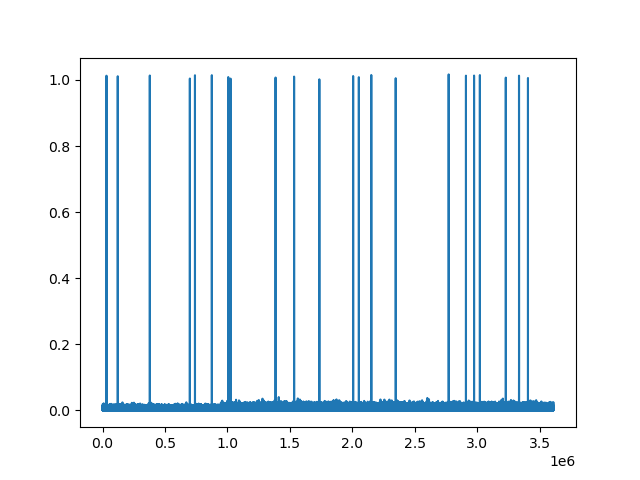

100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.07s/it]


<IPython.core.display.Javascript object>


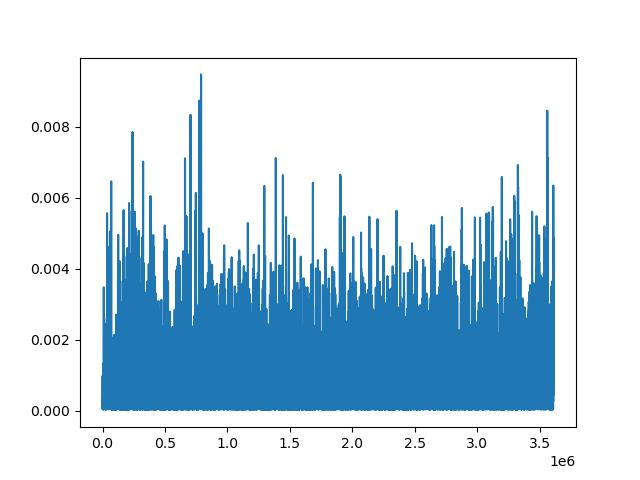

In [18]:
pref_plot_vqt = False
pref_plot_vqtOutputs = True
device = 'cpu'

### convert the tone signal into bandpassed enveloped
vqt = spectral.VQT(
    Fs_sample=1000,
    Q_lowF=2,
    Q_highF=2,
    F_min=70,
    F_max=110,
    n_freq_bins=1,
    win_size=201,
    downsample_factor=1,
    DEVICE_compute=device,
    DEVICE_return='cpu',
    return_complex=False,
    filters=None,
    plot_pref=pref_plot_vqt,
)
sig_toneSpec__idx_ws = vqt(np.array(ws['tone']))[0].numpy()[0]

if pref_plot_vqtOutputs:
    plt.figure()
    plt.plot(sig_toneSpec__idx_ws)

### convert accelerometer signal into bandpassed envelope
###  and average x,y,z together
vqt = spectral.VQT(
    Fs_sample=1000,
    Q_lowF=3,
    Q_highF=3,
    F_min=25,
    F_max=25,
    n_freq_bins=1,
    win_size=501,
    downsample_factor=1,
    DEVICE_compute=device,
    DEVICE_return='cpu',
    return_complex=False,
    filters=None,
    plot_pref=pref_plot_vqt,
)
sig = np.array(ws[['acc_x', 'acc_y', 'acc_z']]).T
sig = sig - sig.mean(1, keepdims=True)
sig_accSpec__idx_ws = vqt(sig).numpy().squeeze().mean(0)

if pref_plot_vqtOutputs:
    plt.figure()
    plt.plot(sig_accSpec__idx_ws)

In [22]:
## Get event times for different wavesurfer signals

pref_plot_peakFinding = False

print(f'## finding peaks in wavesurfer signals. time: {time.ctime()}')

sig_SIFrameTimes__idx_ws = util.get_pulseTimes(ws['X_galvo'] > 0, thresh_derivative=0.5, pref_plot=pref_plot_peakFinding)[0]

sig_lickTimes__idx_ws = util.get_pulseTimes(np.vstack((ws['lick_L'] , ws['lick_R'])).T * -1, thresh_derivative=0.5, pref_plot=pref_plot_peakFinding)

sig_camPulseTimes__idx_ws = util.get_pulseTimes(sig=ws['camPulses'] > 3.5, thresh_derivative=0.5, pref_plot=pref_plot_peakFinding)[0]
sig_camPulseTimes__idx_cam = util.get_pulseTimes(sig=cameraCSV[:,0], thresh_derivative=0.5, pref_plot=pref_plot_peakFinding)[0]

sig_toneTimes__idx_ws = scipy.signal.find_peaks(sig_toneSpec__idx_ws * (sig_toneSpec__idx_ws>0.5), distance=200)[0]
if pref_plot_peakFinding:
    plt.figure(); plt.plot(sig_toneSpec__idx_ws); plt.plot(sig_toneTimes__idx_ws, sig_toneSpec__idx_ws[sig_toneTimes__idx_ws], '.')

## finding peaks in wavesurfer signals. time: Tue Jun  7 03:04:32 2022


In [20]:
## Check to make sure indices check out

match__wsFlybacks_s2pFrames = (len(sig_SIFrameTimes__idx_ws) == F.shape[1])
print(f'number of flybacks matches number of s2p samples') if match__wsFlybacks_s2pFrames else print(f'WARNING: number of ws flybacks {len(sig_SIFrameTimes__idx_ws)} does not match number of s2p frames {F.shape[1]}')

match__wsFlybacks_s2pFrames = (len(sig_camPulseTimes__idx_cam) == len(sig_camPulseTimes__idx_ws))
print(f'number of camPulses sent/received on ws matches number of camPulses from camera CSV file') if match__wsFlybacks_s2pFrames else print(f'WARNING: number of sent camPulses from ws {len(sig_camPulseTimes__idx_cam)} does not match number of received camPulses from camera CSV file {len(sig_camPulseTimes__idx_ws)}')

number of flybacks matches number of s2p samples
number of camPulses sent/received on ws matches number of camPulses from camera CSV file


In [24]:
### convert some wavesurfer signals into SI indices

## first, convert the binary signals from ws into boolean traces, still in ws indices
print(f'## converting wavesurfer signal event times into boolean traces. time: {time.ctime()}')

num_samples_ws = ws.shape[0]

sig_lickBool__idx_ws = np.array([indexing.idx2bool(sig, length=num_samples_ws) for sig in sig_lickTimes__idx_ws]).T

sig_toneBool__idx_ws = indexing.idx2bool(sig_toneTimes__idx_ws, length=num_samples_ws)


## second, integrate boolean signals over SI indices
print(f'## converting wavesurfer boolean signals into SI indices. time: {time.ctime()}')

num_frames_SI = len(sig_SIFrameTimes__idx_ws)
print(f'number of frames from scanimage movie: {num_frames_SI}')

sig_lickBool__idx_SI = np.zeros((num_frames_SI, sig_lickBool__idx_ws.shape[1]))
for i_frame, frame_ind in enumerate(sig_SIFrameTimes__idx_ws):
    if i_frame==0:
        continue
    sig_lickBool__idx_SI[i_frame] = np.sum(sig_lickBool__idx_ws[sig_SIFrameTimes__idx_ws[i_frame-1] : sig_SIFrameTimes__idx_ws[i_frame]], axis=0) > 0.5

## third, convert the analog signals from ws into SI indices
print(f'## converting wavesurfer analog signals into SI indices. time: {time.ctime()}')

sig_accSpec_idx_SI = scipy.interpolate.interp1d(
    x=np.arange(0, num_samples_ws),
    y=sig_accSpec__idx_ws,
    kind='cubic',
)(sig_SIFrameTimes__idx_ws)

sig_toneSpec_idx_SI = scipy.interpolate.interp1d(
    x=np.arange(0, num_samples_ws),
    y=sig_toneSpec__idx_ws,
    kind='cubic',
)(sig_SIFrameTimes__idx_ws)


## converting wavesurfer signal event times into boolean traces. time: Tue Jun  7 03:06:06 2022
## converting wavesurfer boolean signals into SI indices. time: Tue Jun  7 03:06:06 2022
number of frames from scanimage movie: 18504
## converting wavesurfer analog signals into SI indices. time: Tue Jun  7 03:06:06 2022


num peaks: 3610


<IPython.core.display.Javascript object>


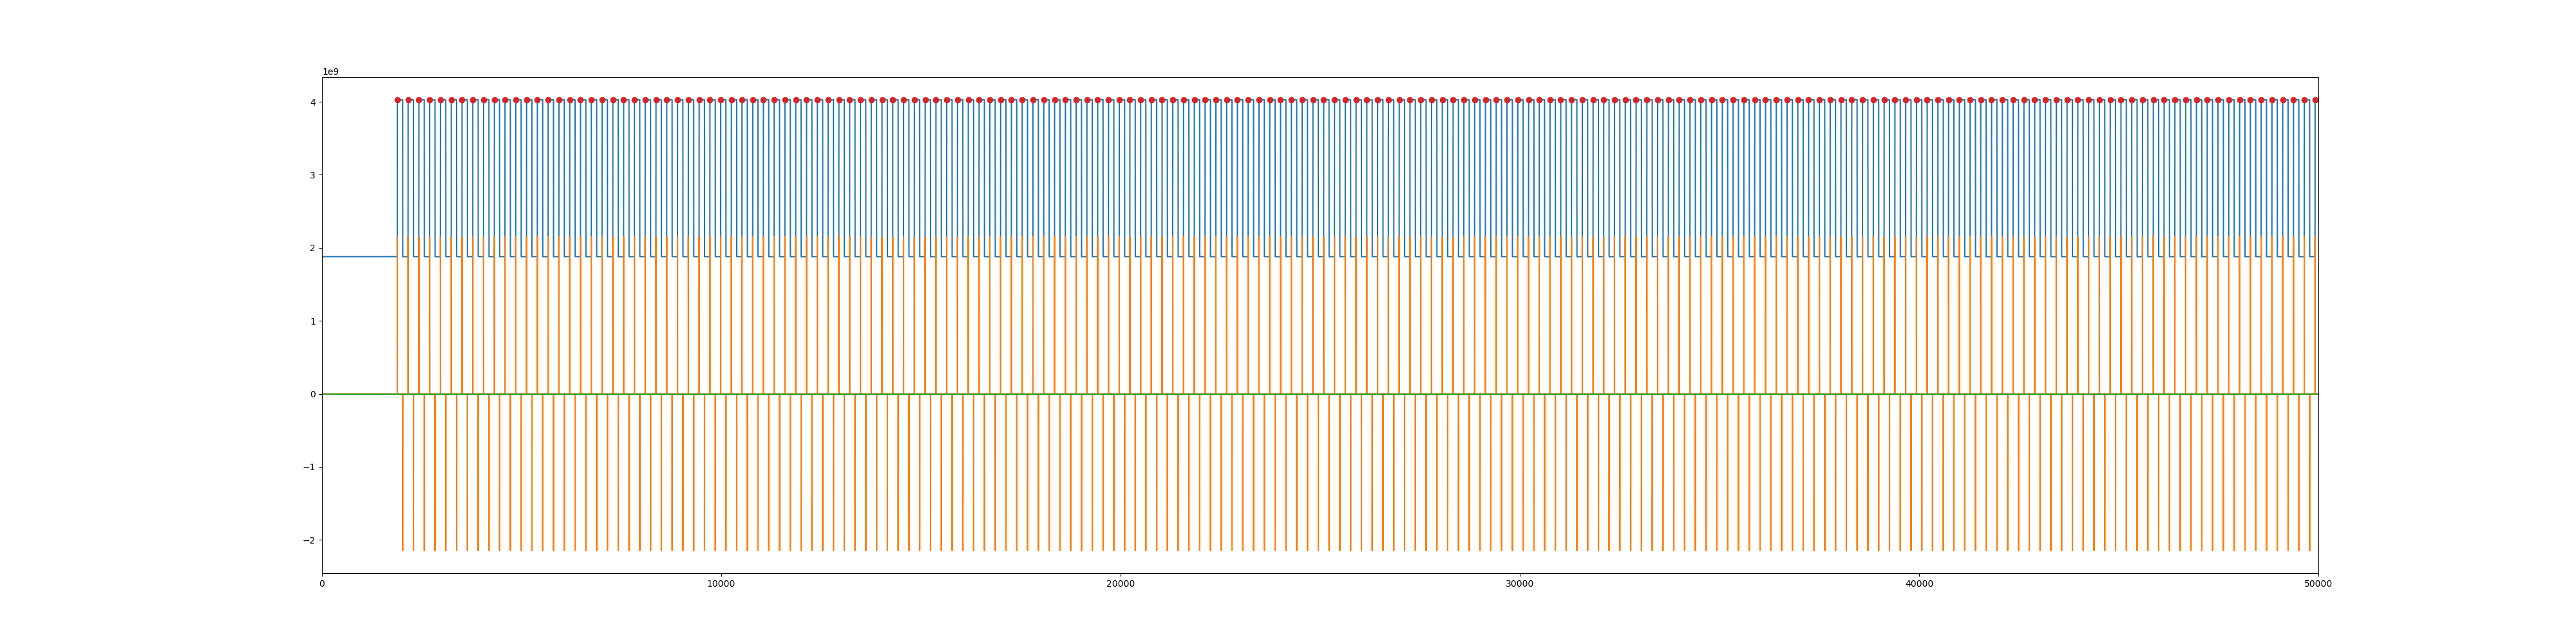

In [23]:
sig_camPulses__idx_cam = cameraCSV[:,0]
sig_camDatetimes__idx_cam = cameraCSV[:,3]

sig_camPulseTimes__idx_cam = util.get_pulseTimes(
    sig=sig_camPulses__idx_cam,
    thresh_derivative=0.5,
    pref_plot=True
)[0]

sig_camDatetimesAbsolute__idx_cam = align_data.convert_camTimeDates_toAbsoluteSeconds(sig_camDatetimes__idx_cam)

sig_wsIdx__idx_cam, sig_wsIdxRounded__idx_cam = util.align_camFrames_toWS(
    sig_camPulseTimes__idx_cam=sig_camPulseTimes__idx_cam,
    sig_camDatetimesAbsolute__idx_cam=sig_camDatetimesAbsolute__idx_cam,
    sig_camPulses__idx_ws=sig_camPulseTimes__idx_ws
)

In [6]:
import torch

device = torch_helpers.set_device(use_GPU=True)

device: 'cuda:0'


<IPython.core.display.Javascript object>


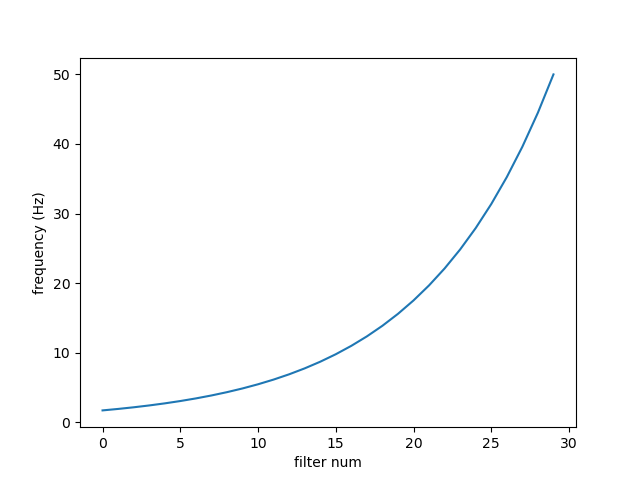

<IPython.core.display.Javascript object>


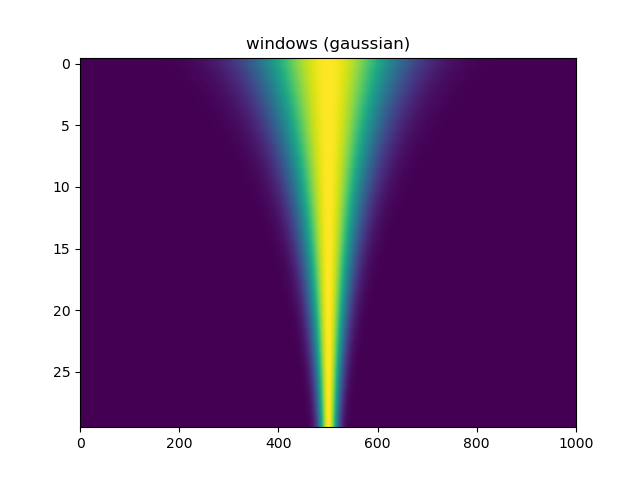

<IPython.core.display.Javascript object>


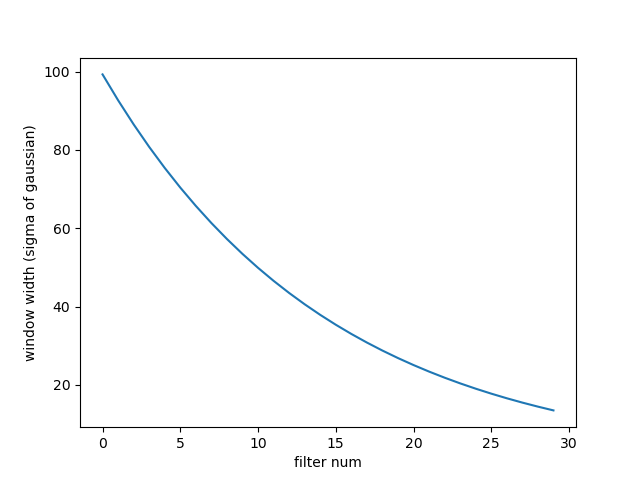

<IPython.core.display.Javascript object>


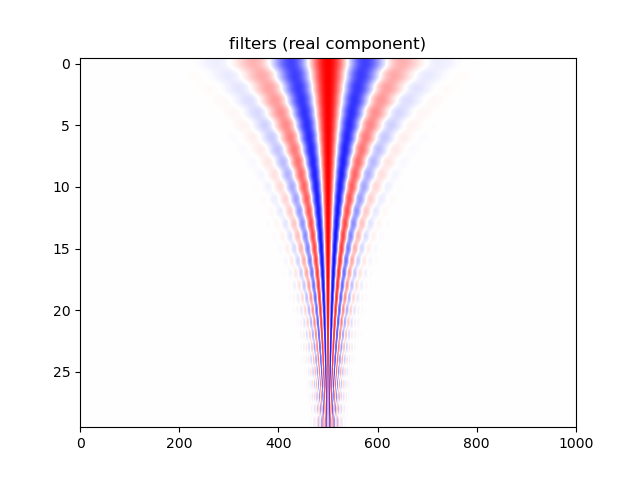

<IPython.core.display.Javascript object>


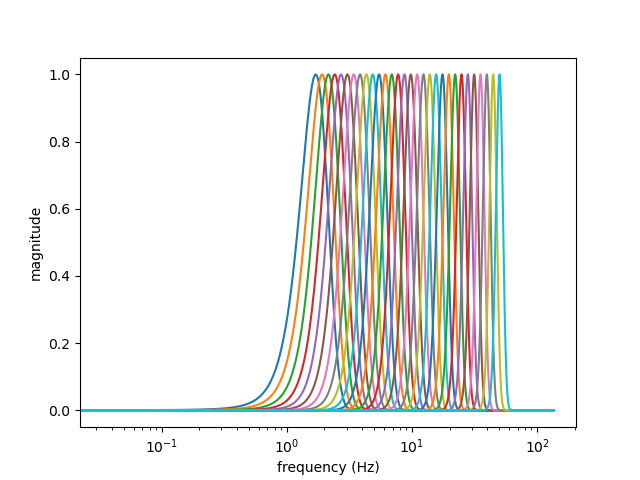

In [17]:
vqt = spectral.VQT(
    Fs_sample=270,
    Q_lowF=2.5,
    Q_highF=10,
    F_min=1.7,
    F_max=50,
    n_freq_bins=30,
    win_size=1001,
    downsample_factor=1,
    DEVICE_compute=device,
    DEVICE_return=device,
    return_complex=False,
    filters=None,
    plot_pref=True,
    progressBar=False,
)

In [18]:
from tqdm.notebook import tqdm

from torchinterp1d import torchinterp1d

interp = torchinterp1d.interp1d.Interp1d()

y = torch.as_tensor(pos_CDR[:,:,:], dtype=torch.float32)

x = torch.as_tensor(sig_wsIdx__idx_cam, dtype=torch.float32)
xnew = torch.as_tensor(sig_SIFrameTimes__idx_ws, dtype=torch.float32)

In [23]:
x_tiled = torch.tile(x, (len(vqt.freqs), 1)).to(device)
xnew_tiled = xnew.to(device)

sig_Sxx__idx_s2p = torch.stack([
    torch.stack([
        interp(
            x=x_tiled, 
            y=vqt(y[ii,jj,...]).squeeze(), 
            xnew=xnew_tiled,
        ).cpu() for ii in tqdm(range(y.shape[0]))
    ], dim=0) for jj in range(y.shape[1])
], dim=0).permute(1,0,2,3)

  0%|          | 0/841 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

In [24]:
spectrogram_exponent = 1

tmp = (sig_Sxx__idx_s2p * vqt.freqs[None,None,:,None]) ** spectrogram_exponent
tmp_normFactor = torch.mean(tmp, dim=(0,1,2))

In [25]:
norm_factor = 0.9

sig_SxxNorm__idx_s2p = tmp / ((tmp_normFactor[None,None,None,:] * norm_factor) + (1-norm_factor))

In [26]:
x_tiled = torch.tile(x, (y.shape[1], 1)).to(device)
xnew_tiled = xnew.to(device)

sig_posCDR__idx_s2p = torch.stack([interp(x=x_tiled, y=y[ii,:,:].to(device), xnew=xnew_tiled).cpu() for ii in tqdm(range(y.shape[0]))], dim=0)

  0%|          | 0/841 [00:00<?, ?it/s]

In [ ]:
# ## Save outputs

# h5_handling.simple_save()

In [ ]:
# resource requirements
# RAM: 64GB
# VRAM: 8GB
# CPU: any number
# 10 min